In [1]:
# !pip install lxml

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 500
plt.rcParams['font.size'] = '16'
sns.set_style('whitegrid')

In [2]:
link = pd.read_html('https://genshin-impact.fandom.com/wiki/Wishes/History')

In [150]:
df = link[1]
df = df.dropna()

In [151]:
df.Featured = df.Featured.str.split().apply(lambda x: x[0])
df = df.drop('Wish', axis=1)

In [152]:
df = df[df.Featured != '—']

In [153]:
df.head()

,Featured,Duration
0,Venti,"September 28, 2020 – October 18, 2020"
4,Klee,"October 20, 2020 – November 10, 2020"
6,Tartaglia,"November 11, 2020 – December 1, 2020"
8,Zhongli,"December 1, 2020 – December 22, 2020"
10,Albedo,"December 23, 2020 – January 12, 2021"


In [154]:
paired_df = (df.groupby('Duration').Featured.count() == 2).reset_index()
paired_df = paired_df.rename(
    columns={
        'Featured': 'Paired'
    }
)
paired_df.Paired = paired_df.Paired.astype(int)

df = pd.merge(df, paired_df, left_on='Duration' \
         , right_on='Duration', how='inner')

In [155]:
df.head()

,Featured,Duration,Paired
0,Venti,"September 28, 2020 – October 18, 2020",0
1,Klee,"October 20, 2020 – November 10, 2020",0
2,Tartaglia,"November 11, 2020 – December 1, 2020",0
3,Zhongli,"December 1, 2020 – December 22, 2020",0
4,Albedo,"December 23, 2020 – January 12, 2021",0


In [156]:
df.Duration = df.Duration.apply(lambda x: x.split('–')[0])
df['Date'] = pd.to_datetime(df.Duration, infer_datetime_format=True)
df = df.drop('Duration', axis=1)

In [157]:
df.isna().any()

Featured    False
Paired      False
Date        False
dtype: bool

In [158]:
df.head()

,Featured,Paired,Date
0,Venti,0,2020-09-28
1,Klee,0,2020-10-20
2,Tartaglia,0,2020-11-11
3,Zhongli,0,2020-12-01
4,Albedo,0,2020-12-23


In [159]:
df = df.rename(
    columns={
        'Featured': 'Character'
    }
)

In [160]:
df.head()

,Character,Paired,Date
0,Venti,0,2020-09-28
1,Klee,0,2020-10-20
2,Tartaglia,0,2020-11-11
3,Zhongli,0,2020-12-01
4,Albedo,0,2020-12-23


In [161]:
df['CurrentRerunDelta'] = pd.to_datetime(datetime.date(datetime.now())) - df.Date

In [162]:
df.head()

,Character,Paired,Date,CurrentRerunDelta
0,Venti,0,2020-09-28,582 days
1,Klee,0,2020-10-20,560 days
2,Tartaglia,0,2020-11-11,538 days
3,Zhongli,0,2020-12-01,518 days
4,Albedo,0,2020-12-23,496 days


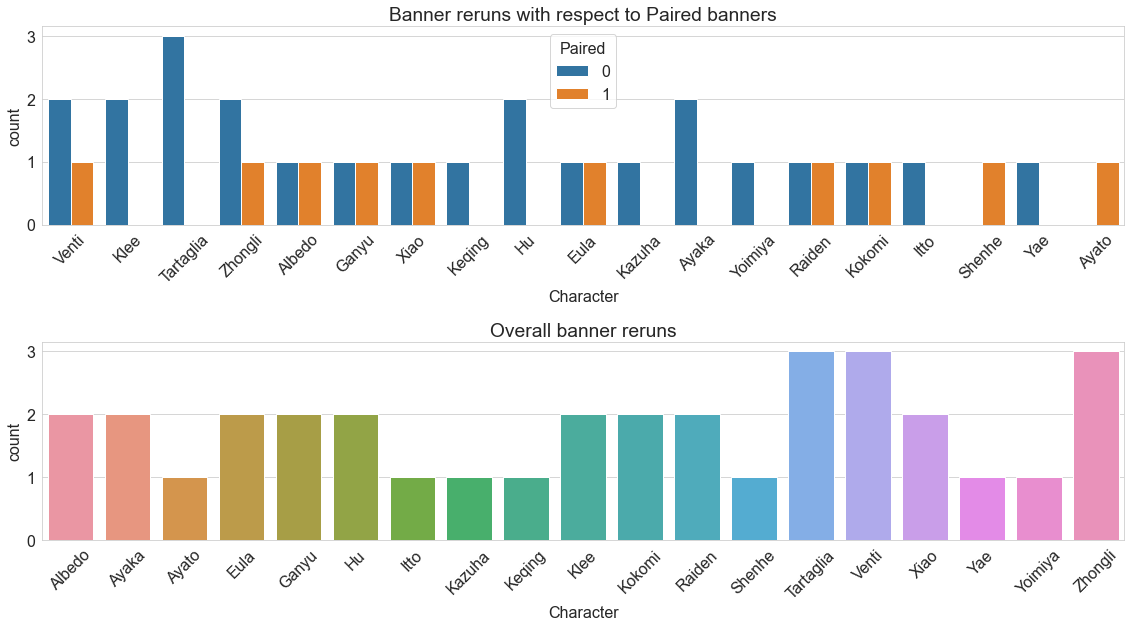

In [163]:
banner_counts = df.groupby('Character').Date.count()

fig = plt.figure(figsize=(16, 9))

ax1 = fig.add_subplot(2, 1, 1)
sns.countplot(x=df.Character, hue=df.Paired)
plt.title('Banner reruns with respect to Paired banners')
plt.xticks(rotation=45)



ax2 = fig.add_subplot(2, 1, 2)
sns.barplot(x=banner_counts.index, y=banner_counts)
plt.title('Overall banner reruns')
plt.xticks(rotation=45)
plt.ylabel('count')

plt.tight_layout()

In [164]:
tables_2 = pd.read_html('https://www.bulletinsun.com/2022/01/'
                        'Genshin-Impact-pick-rates-Full-list-of-each-Genshin-Impact-character.html')

In [165]:
pick_rate_df = tables_2[0]
pick_rate_df = pick_rate_df.loc[1:]
pick_rate_df.columns = ['Rank', 'Character', 'Element', 'Popularity']

pick_rate_df = pick_rate_df.drop(['Rank'], axis=1)
pick_rate_df.Character = pick_rate_df.Character.apply(
    lambda x: x.split()[1] if len(x.split()) > 1 else x.split()[0]
)
pick_rate_df.Popularity = pick_rate_df.Popularity.apply(lambda x: float(x[:-1]))
# pick_rate_df.at(13, 'Character') = 'Itto'

In [166]:
tables_3 = pd.read_html('https://genshin-impact.fandom.com/wiki/Characters/List')

In [167]:
character_df = tables_3[1]
character_df.columns = ['Icon', 'Character', 'Rarity', 'Element', 'Weapon', 'Region']

In [168]:
character_df.Character = character_df.Character.apply(
    lambda x: x.split()[1] if len(x.split()) > 1 else x.split()[0]
)

In [169]:
# character_df

In [170]:
full_characters = pd.merge(pick_rate_df.drop('Element', axis=1) \
         , character_df[['Character', 'Element', 'Weapon', 'Region']] \
         , on='Character', how='right')

In [171]:
full_characters.at[14, 'Character'] = 'Hu'
full_characters.at[28, 'Character'] = 'Raiden'
full_characters.at[43, 'Character'] = 'Yae'

In [173]:
# full_characters

In [175]:
df = pd.merge(df, full_characters, on='Character', how='left')

In [176]:
df.isna().any()

Character            False
Paired               False
Date                 False
CurrentRerunDelta    False
Popularity            True
Element              False
Weapon               False
Region               False
dtype: bool

In [181]:
banner_counts = df.groupby('Character').Date.count().reset_index()

banner_counts = banner_counts.rename(
    columns={
        'Date': 'Appearances'
    }
)

df = pd.merge(df, banner_counts)

In [182]:
from datetime import timedelta

df['NextRerunDelta'] = df.groupby('Character').Date.diff()
df.NextRerunDelta = df.NextRerunDelta.fillna(timedelta(0))

df['MaxRerunDelta'] = df.groupby('Character').NextRerunDelta.transform('max')
df = df.drop('NextRerunDelta', axis=1)

# df[df.MaxRerunDelta == timedelta(0)].MaxRerunDelta = df.LatestRerunDelta

In [187]:
unique_df = df.drop_duplicates('Character', keep='last').copy()
unique_df.Popularity = unique_df.Popularity.fillna(
    unique_df.Popularity.mean()
).round(2)

In [189]:
unique_df = unique_df[unique_df.Character != 'Keqing']

In [191]:
unique_df.isna().sum()

Character            0
Paired               0
Date                 0
CurrentRerunDelta    0
Popularity           0
Element              0
Weapon               0
Region               0
Appearances          0
MaxRerunDelta        0
dtype: int64

In [193]:
unique_df.MaxRerunDelta = np.where(unique_df.MaxRerunDelta == timedelta(0) \
                                   , unique_df.CurrentRerunDelta, unique_df.MaxRerunDelta)

<AxesSubplot:>

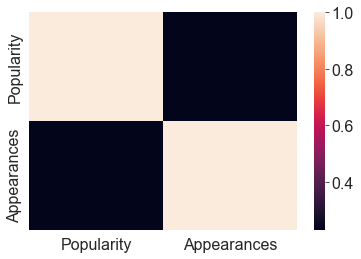

In [194]:
sns.heatmap(unique_df[['Popularity', 'Appearances']].corr())

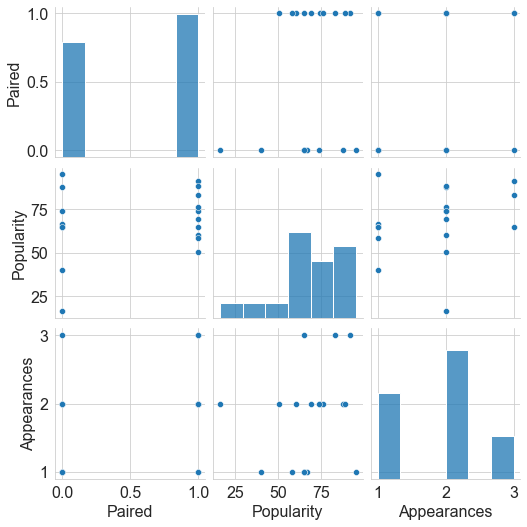

In [195]:
sns.pairplot(unique_df)

<AxesSubplot:title={'center':"Banners' count with respect to elements"}, xlabel='Element', ylabel='count'>

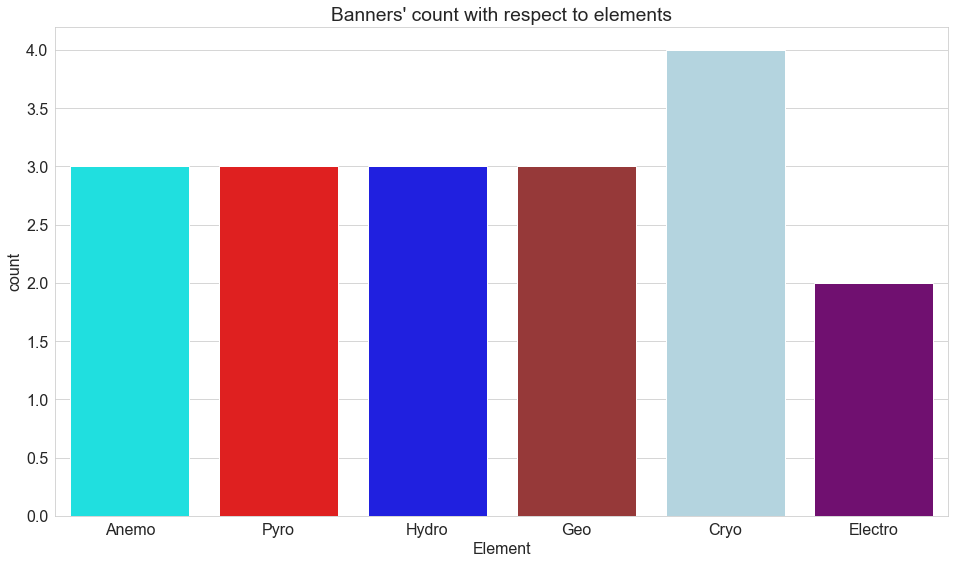

In [197]:
fig = plt.figure(figsize=(16, 9))

plt.title("Banners' count with respect to elements")
colors = ['cyan', 'red', 'blue', 'brown', 'lightblue', 'purple']
sns.countplot(x=unique_df.Element, palette=colors)

<AxesSubplot:xlabel='Popularity', ylabel='Appearances'>

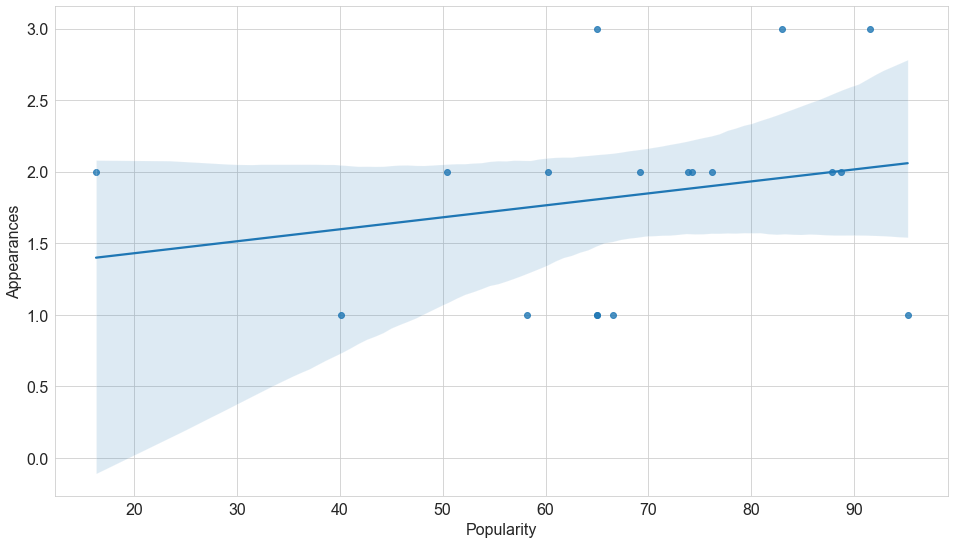

In [198]:
fig = plt.figure(figsize=(16, 9))

sns.regplot(unique_df.Popularity, unique_df.Appearances)

<AxesSubplot:xlabel='Popularity', ylabel='Appearances'>

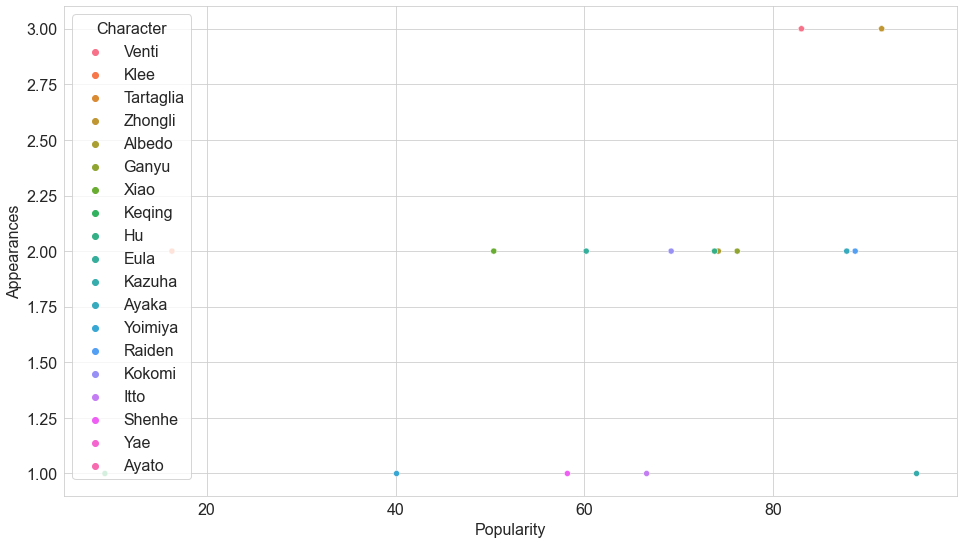

In [199]:
plt.figure(figsize=(16, 9))
sns.scatterplot(x=df.Popularity, y=df.Appearances, hue=df.Character)

<AxesSubplot:>

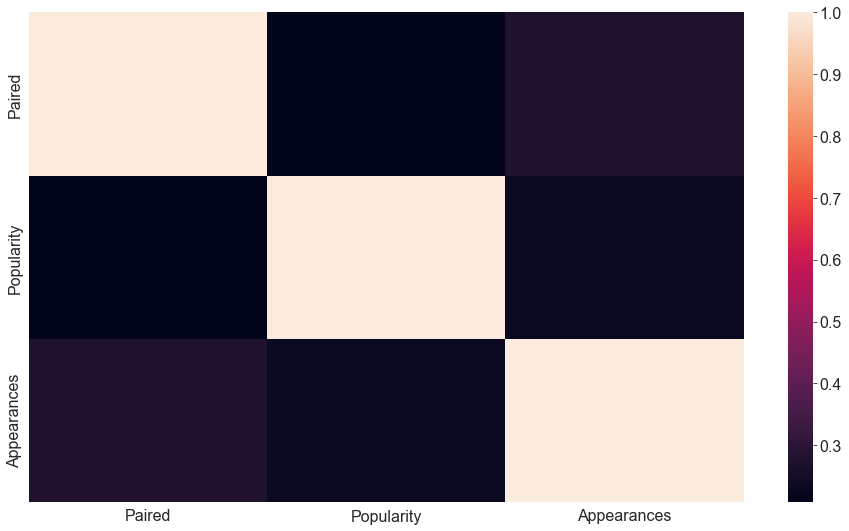

In [200]:
numeric_columns = unique_df.loc[:, unique_df.dtypes != object].columns

fig = plt.figure(figsize=(16, 9))
sns.heatmap(unique_df[numeric_columns].corr())

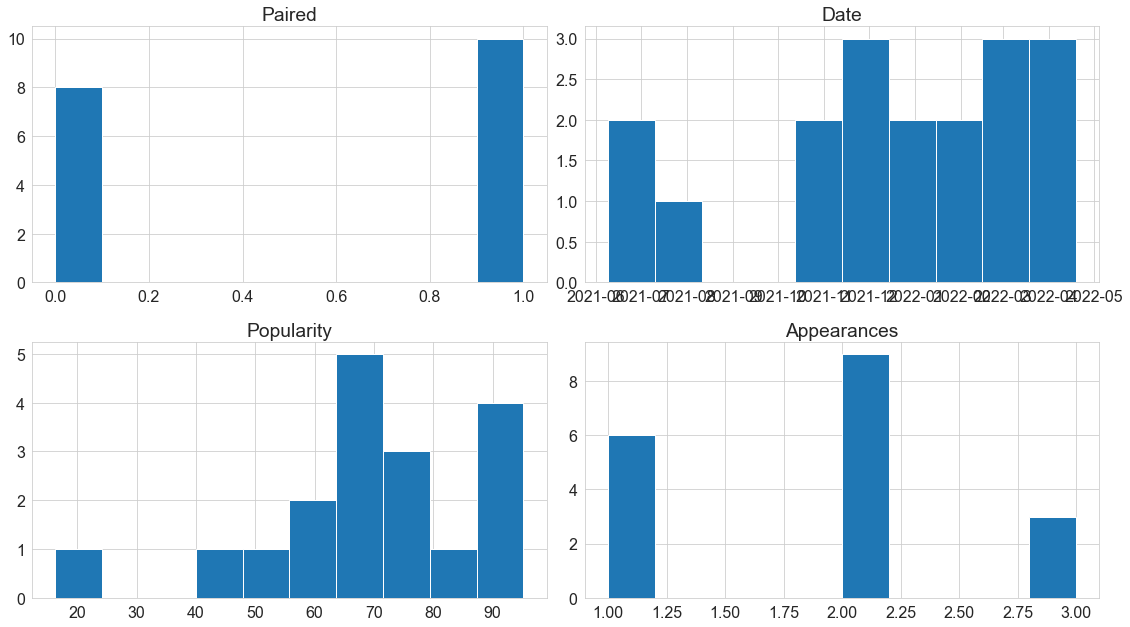

In [201]:
ax = unique_df[numeric_columns].hist(figsize=(16, 9))
plt.tight_layout()

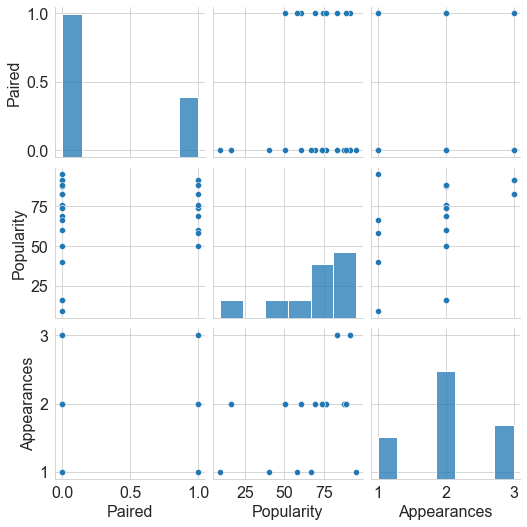

In [202]:
sns.pairplot(df[numeric_columns])

In [203]:
unique_df.sort_values(by=['CurrentRerunDelta', 'Popularity', 'Appearances'] \
                      , ascending=[False, False, True])

,Character,Paired,Date,CurrentRerunDelta,Popularity,Element,Weapon,Region,Appearances,MaxRerunDelta
4,Klee,0,2021-06-09,328 days,16.30,Pyro,Catalyst,Mondstadt,2,232 days
22,Kazuha,0,2021-06-29,308 days,95.20,Anemo,Sword,Inazuma,1,308 days
25,Yoimiya,0,2021-08-10,266 days,40.10,Pyro,Bow,Inazuma,1,266 days
7,Tartaglia,0,2021-10-13,202 days,65.04,Hydro,Bow,Snezhnaya,3,190 days
19,Hu,0,2021-11-02,182 days,73.80,Pyro,Polearm,Liyue,2,245 days
12,Albedo,1,2021-11-24,160 days,74.20,Geo,Sword,Mondstadt,2,336 days
21,Eula,1,2021-11-24,160 days,60.20,Cryo,Claymore,Mondstadt,2,190 days
30,Itto,0,2021-12-14,140 days,66.60,Geo,Claymore,Inazuma,1,140 days
31,Shenhe,1,2022-01-05,118 days,58.20,Cryo,Polearm,Liyue,1,118 days
16,Xiao,1,2022-01-05,118 days,50.40,Anemo,Polearm,Liyue,2,336 days
